# Libraries

##  Remove warnings

In [1]:
import warnings
warnings.filterwarnings("ignore")

## Import libraries

In [2]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Basic libraries
#
import time
import pandas    as pd
import numpy     as np
from   tqdm      import tqdm


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization library
#
import matplotlib.pyplot   as plt 


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Sklearn library
#
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# PyTorch library
#
import torch
import torch.nn                     as nn
import torch.nn.functional          as F
from   torch.utils.data             import TensorDataset
from   torch.utils.data             import DataLoader

# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
#
# User libraries
#
from utils.EarlyStopping      import *
from utils.LRScheduler        import *
from utils.LossFunctions      import *
from utils.PerformanceMetrics import RegressionEvaluation
from utils.plot_scatter       import *

# Parameters

In [3]:
import random, os
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

## Setup CUDA

In [4]:
try:
    torch.cuda.init()

    if (torch.cuda.is_available() == True):
        print('[INFO] CUDA is available')

        device = torch.device( 'cuda:0' )
        print('[INFO] Device name: %s' % torch.cuda.get_device_name(0))

    else:
        print('[INFO] CUDA is not available')
        device = torch.device( 'cpu' )
except:
    print('[INFO] CUDA is not available')

# device = torch.device( 'cpu' )

[INFO] CUDA is available
[INFO] Device name: Quadro GV100


## Data handling parameters

In [5]:
# Parameters
#
filename   = 'Data/Temperature.csv'

Transformation  = True
Scaling         = 'Standard'

## Neural networks parameters

In [6]:
Lag        =   48
Horizon    =    6
#
epochs     = 2000
batch_size =   16

# Data handling

## Import data


In [7]:
# Start timer
#
start = time.time()

# Load data
#
df = pd.read_csv( filename )

print('[INFO] Data imported')
print('[INFO] Time: %.2f seconds' % (time.time() - start))

df.head(3)

[INFO] Data imported
[INFO] Time: 0.01 seconds


,Date,Temperature
0,2015-02-11 14:48:00,21.7600
1,2015-02-11 14:49:00,21.7900
2,2015-02-11 14:50:00,21.7675


## Preprocess data

### Set index

In [8]:
# Convert Date to 'datetime64'
#
df['Date'] = df['Date'].astype('datetime64')

# Set index
#
df.set_index('Date', inplace=True)

df.head(3)

,Temperature
Date,
2015-02-11 14:48:00,21.7600
2015-02-11 14:49:00,21.7900
2015-02-11 14:50:00,21.7675


In [9]:
# Set target series
#
targetSeries = df.columns[-1]

### Split Training/Testing

In [10]:
idx = int( df.shape[0] * 0.8 )

df_train = df[ :idx ]
df_test  = df[ idx: ]

### Visualization

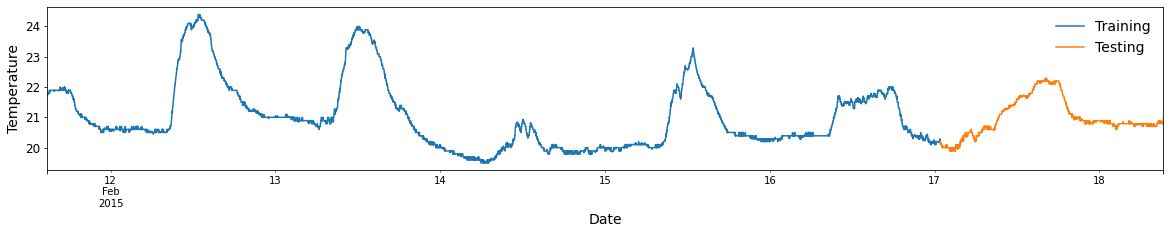

In [11]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 3) )

df_train[targetSeries].plot(ax=ax, color='tab:blue' )
df_test[targetSeries].plot(ax=ax,  color='tab:orange')

plt.legend(['Training', 'Testing'], frameon = False, fontsize = 14)
plt.ylabel(targetSeries, size = 14)
plt.xlabel('Date', size = 14);
plt.xticks(size = 12);
plt.yticks(size = 12);

### Fixing Lag

In [12]:
df_test = pd.concat([df_train.iloc[-Lag:], df_test])

## Preprocessing

## Data Transformation

In [13]:
if (Transformation == True):
    
    print('[INFO] Data transformation applied')
        
    df_train = np.log( df_train )
    df_test  = np.log( df_test  )   
    
else:
    print('[INFO] No data transformation applied.')    

[INFO] Data transformation applied


In [14]:
if (Scaling == 'MinMax'):
    print('[INFO] Scaling: MinMax')
    
    # Set scaler
    #
    scaler = MinMaxScaler()

    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
        
elif (Scaling == 'Robust'):
    print('[INFO] Scaling: Robust')
    
    # Set scaler
    #
    scaler = RobustScaler()
     
    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
        
elif (Scaling == 'Standard'):
    print('[INFO] Scaling: Standard')
    
    # Set scaler
    #
    scaler = StandardScaler()

    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
           
else:
    print('[WARNING] Unknown data scaling. Standar scaling was selected')   
    
    # Set scaler
    #
    scaler = StandardScaler()

    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )    

[INFO] Scaling: Standard


## Create Training/Testing data

In [15]:
def create_dataset(df = None, Lag = 1, Horizon = 12, targetSeries = None, overlap = 1):
    
    if (targetSeries is None):
        targetSeries = df.columns[-1]
    
    dataX, dataY = [], []
    for i in tqdm( range(0, df.shape[0] + 1  - Lag - Horizon, overlap) ):
        
        dataX.append( df.to_numpy()[i:(i+Lag)] )        
        dataY.append( df[ targetSeries ].to_numpy()[i + Lag : i + Lag + Horizon] )
        
        
    return ( np.array(dataX), np.array(dataY) )

In [16]:
trainX, trainY = create_dataset(df           = df_train, 
                                Lag          = Lag, 
                                Horizon      = Horizon, 
                                targetSeries = targetSeries,
                                overlap      = 3)

testX,  testY  = create_dataset(df           = df_test, 
                                Lag          = Lag, 
                                Horizon      = Horizon, 
                                targetSeries = targetSeries)

print('Training instances:   %6i' % trainX.shape[0])
print('Testing instances:    %6i' % testX.shape[0])

100%|██████████| 1946/1946 [00:00<00:00, 65705.35it/s]

Training instances:     2583
Testing instances:      1946


## Reshape (needed for NBeats)

In [17]:
trainX = trainX.squeeze(-1)
testX   = testX.squeeze(-1)

# Forecasting model: NBeats

## Setup dataloaders

In [18]:
# Create training and test dataloaders
#
num_workers = 0


# Prepare Data-Loaders
#
trainData = TensorDataset( torch.Tensor(trainX), torch.Tensor(trainY) )
testData  = TensorDataset( torch.Tensor(testX),  torch.Tensor(testY)  )
#
#
train_loader = torch.utils.data.DataLoader(trainData, batch_size=batch_size, num_workers=num_workers)
test_loader  = torch.utils.data.DataLoader(testData,  batch_size=batch_size, num_workers=num_workers)

## Setup model

In [19]:
from utils.NBeats_PyTorch import NBeatsNet

model = NBeatsNet(stack_types        = (NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
                  forecast_length    = Horizon,
                  backcast_length    = Lag,
                  hidden_layer_units = 64,
                  device = device)
model.to(device);

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=64, thetas_dim=4, backcast_length=48, forecast_length=6, share_thetas=False) at @140030299447504
     | -- GenericBlock(units=64, thetas_dim=4, backcast_length=48, forecast_length=6, share_thetas=False) at @140030481760336
     | -- GenericBlock(units=64, thetas_dim=4, backcast_length=48, forecast_length=6, share_thetas=False) at @140030298799568
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=64, thetas_dim=8, backcast_length=48, forecast_length=6, share_thetas=False) at @140030298734864
     | -- GenericBlock(units=64, thetas_dim=8, backcast_length=48, forecast_length=6, share_thetas=False) at @140030299032400
     | -- GenericBlock(units=64, thetas_dim=8, backcast_length=48, forecast_length=6, share_thetas=False) at @140030481764240


## Training parameters

In [20]:
# plot utils.
def plot_scatter(*args, **kwargs):
    plt.plot(*args, **kwargs)
    plt.scatter(*args, **kwargs)

In [21]:
# Setup Loss-function
#
criterion = nn.MSELoss()

# Specify loss function
#
optimizer = torch.optim.Adam(params = model.parameters(), 
                             lr     = 5.e-4)


# Define verbose
#
verbose = True


# Early stopping
#
early_stopping = EarlyStopping(patience  = 200,
                               min_delta = 0)


# LR scheduler
#
scheduler = LRScheduler(optimizer = optimizer, 
                        patience  = 100, 
                        min_lr    = 1e-7, 
                        factor    = 0.5, 
                        verbose   = True)

## Training process

> Epoch: 1 [  640/2583 (25%)]
> Epoch: 1 [ 1280/2583 (49%)]
> Epoch: 1 [ 1920/2583 (74%)]
> Epoch: 1 [ 2560/2583 (99%)]

[INFO] Train Loss: 7.686740 	Valid Loss: 0.508277 	Time: 5.10secs
(Model saved)

> Epoch: 2 [  640/2583 (25%)]
> Epoch: 2 [ 1280/2583 (49%)]
> Epoch: 2 [ 1920/2583 (74%)]
> Epoch: 2 [ 2560/2583 (99%)]

[INFO] Train Loss: 1.746155 	Valid Loss: 0.580670 	Time: 4.96secs


> Epoch: 3 [  640/2583 (25%)]
> Epoch: 3 [ 1280/2583 (49%)]
> Epoch: 3 [ 1920/2583 (74%)]
> Epoch: 3 [ 2560/2583 (99%)]

[INFO] Train Loss: 1.356565 	Valid Loss: 0.494429 	Time: 5.00secs
(Model saved)

> Epoch: 4 [  640/2583 (25%)]
> Epoch: 4 [ 1280/2583 (49%)]
> Epoch: 4 [ 1920/2583 (74%)]
> Epoch: 4 [ 2560/2583 (99%)]

[INFO] Train Loss: 1.024825 	Valid Loss: 0.255945 	Time: 5.00secs
(Model saved)

> Epoch: 5 [  640/2583 (25%)]
> Epoch: 5 [ 1280/2583 (49%)]
> Epoch: 5 [ 1920/2583 (74%)]
> Epoch: 5 [ 2560/2583 (99%)]

[INFO] Train Loss: 0.892020 	Valid Loss: 0.357563 	Time: 4.92secs


> Epoch: 6 [  64

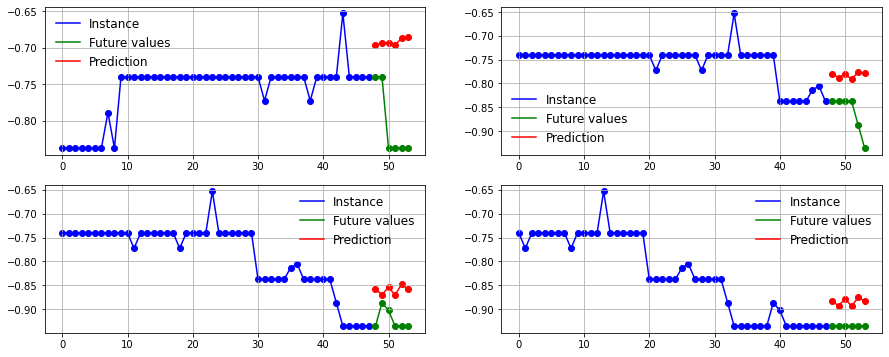


[INFO] Train Loss: 0.093523 	Valid Loss: 0.042741 	Time: 5.60secs


> Epoch: 101 [  640/2583 (25%)]
> Epoch: 101 [ 1280/2583 (49%)]
> Epoch: 101 [ 1920/2583 (74%)]
> Epoch: 101 [ 2560/2583 (99%)]

[INFO] Train Loss: 0.081765 	Valid Loss: 0.032886 	Time: 4.96secs


> Epoch: 102 [  640/2583 (25%)]
> Epoch: 102 [ 1280/2583 (49%)]
> Epoch: 102 [ 1920/2583 (74%)]
> Epoch: 102 [ 2560/2583 (99%)]

[INFO] Train Loss: 0.092711 	Valid Loss: 0.045776 	Time: 4.93secs


> Epoch: 103 [  640/2583 (25%)]
> Epoch: 103 [ 1280/2583 (49%)]
> Epoch: 103 [ 1920/2583 (74%)]
> Epoch: 103 [ 2560/2583 (99%)]

[INFO] Train Loss: 0.111385 	Valid Loss: 0.044202 	Time: 4.84secs


> Epoch: 104 [  640/2583 (25%)]
> Epoch: 104 [ 1280/2583 (49%)]
> Epoch: 104 [ 1920/2583 (74%)]
> Epoch: 104 [ 2560/2583 (99%)]

[INFO] Train Loss: 0.132479 	Valid Loss: 0.048596 	Time: 4.31secs


> Epoch: 105 [  640/2583 (25%)]
> Epoch: 105 [ 1280/2583 (49%)]
> Epoch: 105 [ 1920/2583 (74%)]
> Epoch: 105 [ 2560/2583 (99%)]

[INFO] Train L

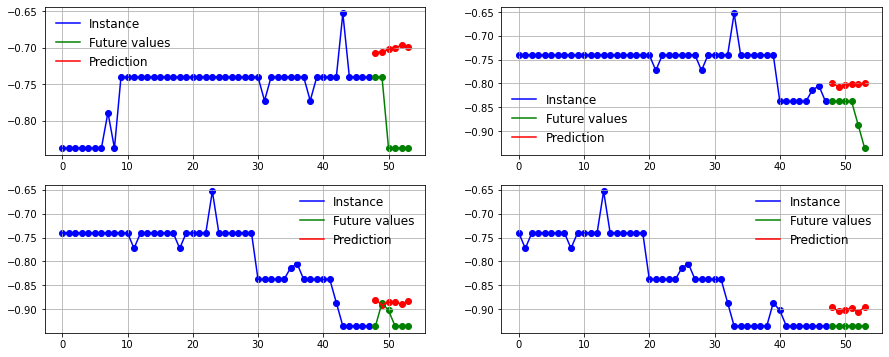


[INFO] Train Loss: 0.035576 	Valid Loss: 0.032839 	Time: 5.69secs


> Epoch: 201 [  640/2583 (25%)]
> Epoch: 201 [ 1280/2583 (49%)]
> Epoch: 201 [ 1920/2583 (74%)]
> Epoch: 201 [ 2560/2583 (99%)]

[INFO] Train Loss: 0.034122 	Valid Loss: 0.032317 	Time: 4.94secs


> Epoch: 202 [  640/2583 (25%)]
> Epoch: 202 [ 1280/2583 (49%)]
> Epoch: 202 [ 1920/2583 (74%)]
> Epoch: 202 [ 2560/2583 (99%)]

[INFO] Train Loss: 0.034490 	Valid Loss: 0.032121 	Time: 4.93secs


> Epoch: 203 [  640/2583 (25%)]
> Epoch: 203 [ 1280/2583 (49%)]
> Epoch: 203 [ 1920/2583 (74%)]
> Epoch: 203 [ 2560/2583 (99%)]

[INFO] Train Loss: 0.036608 	Valid Loss: 0.031880 	Time: 4.90secs


> Epoch: 204 [  640/2583 (25%)]
> Epoch: 204 [ 1280/2583 (49%)]
> Epoch: 204 [ 1920/2583 (74%)]
> Epoch: 204 [ 2560/2583 (99%)]

[INFO] Train Loss: 0.051792 	Valid Loss: 0.048944 	Time: 4.95secs


> Epoch: 205 [  640/2583 (25%)]
> Epoch: 205 [ 1280/2583 (49%)]
> Epoch: 205 [ 1920/2583 (74%)]
> Epoch: 205 [ 2560/2583 (99%)]

[INFO] Train L

In [22]:
# Store traNBeats_PyTorchvalidation loss
#
Loss = {
         'Train': [], 
         'Valid': []
       }

# Set number at how many iteration the training process (results) will be provided
#
batch_show = (train_loader.dataset.tensors[0].shape[0] // batch_size // 4)



# Main loop - Training process
#
for epoch in range(1, epochs+1):

    # Start timer
    start = time.time()
    
    # Monitor Training/Testing Loss
    train_loss = 0.0
    valid_loss = 0.0
    
    
    
    
    
    ###################
    # Train the model #
    ###################
    batch_idx = 0
    for (x, y) in train_loader:

        # Clear the gradients of all optimized variables
        #
        optimizer.zero_grad()
        
        # Forward pass: compute predicted outputs by passing inputs to the model
        #
        if ( device.type == 'cpu'):
            x = torch.tensor(x, dtype=torch.float32)
            y = torch.tensor(y, dtype=torch.float32)
        else:
            x = torch.tensor(x, dtype=torch.float32).cuda()
            y = torch.tensor(y, dtype=torch.float32).cuda()

            
        
        # Forward pass
        #
        _, outputs = model(x)
        
        
        # Calculate the loss
        #
        loss = criterion(outputs, y)
        
        
        # Backward pass: compute gradient of the loss with respect to model parameters
        #
        loss.backward()
        
        
        
        # Perform a single optimization step (parameter update)
        #
        optimizer.step()
        
        
        
        # Update running training loss
        #
        train_loss += loss.item() * x.size(0)

        batch_idx  += 1
        if (verbose == True and batch_idx % batch_show == 0):
            print('> Epoch: {} [{:5.0f}/{} ({:.0f}%)]'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader)))        

           
        
    # Print avg training statistics 
    #
    train_loss = train_loss / len( train_loader )
    
    
    
    if epoch % 100 == 0:
        subplots = [221, 222, 223, 224]
        plt.figure( figsize = (15, 6) )
        RandomInstances = [1, 11, 21, 31]

        for plot_id, i in enumerate(RandomInstances):
            Instance = torch.tensor(testX[i], dtype=torch.float32)
            _, pred = model( Instance )

            pred = pred.detach().cpu().numpy()

            plt.subplot(subplots[plot_id])
            plt.grid()
            plot_scatter(range(0, Lag), Instance, color='b')
            plot_scatter(range(Lag, Lag + Horizon), testY[i], color='g')
            plot_scatter(range(Lag, Lag + Horizon), pred[0], color='r')

            plt.legend(['Instance', 'Future values', 'Prediction'], frameon = False, fontsize = 12)
        plt.show()
    
    
    
    
    with torch.no_grad():
        for (x, y) in test_loader:


            # Forward pass: compute predicted outputs by passing inputs to the model
            #
            if ( device.type == 'cpu'):
                x = torch.tensor(x, dtype=torch.float32)
                y = torch.tensor(y, dtype=torch.float32)
            else:
                x = torch.tensor(x, dtype=torch.float32).cuda()
                y = torch.tensor(y, dtype=torch.float32).cuda()




            # Forward pass
            #
            _, outputs = model( x ) 

            
            
            # Calculate the loss
            #
            loss = criterion(outputs, y)


            # update running training loss
            #
            valid_loss += loss.item()*x.size(0)

            
    # Print avg training statistics 
    #
    valid_loss = valid_loss / len( test_loader )
    
    
    # Stop timer
    #
    stop  = time.time()
    
    
    # Show training results
    #
    print('\n[INFO] Train Loss: {:.6f} \tValid Loss: {:.6f} \tTime: {:.2f}secs'.format(train_loss, valid_loss, stop-start))
           
    
    # Update best model
    #
    if (epoch == 1):
        Best_validation_score = valid_loss
        
        model.save('models/NBeats_pytorch.pth')
        print('(Model saved)\n')
    else:
        if (Best_validation_score > valid_loss):
            Best_validation_score = valid_loss
            
            model.save('models/NBeats_pytorch.pth')
            print('(Model saved)\n')
        else:
            print('\n')
            
     
    
    # Store train/val loss
    #
    Loss['Train'] += [train_loss]
    Loss['Valid'] += [valid_loss]

    

   
    
    # =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
    # Learning rate scheduler
    #
    scheduler(valid_loss)
    
    
    # =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
    # Early Stopping
    #
    if ( early_stopping(valid_loss) ): break    

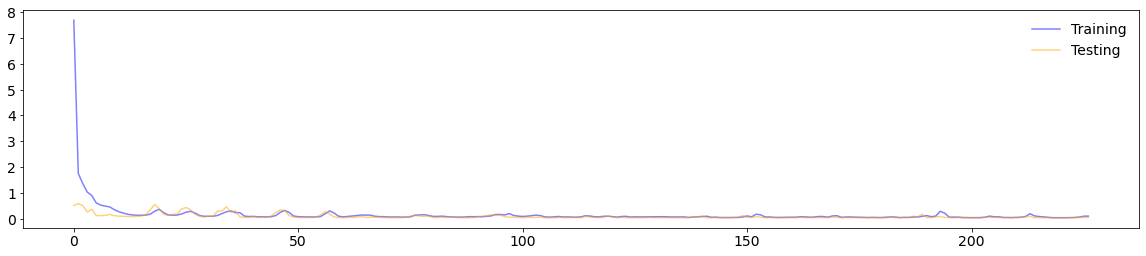

In [23]:
plt.figure( figsize = (20, 4) );

plt.plot( Loss['Train'], color='blue',   alpha= 0.5);
plt.plot( Loss['Valid'], color='orange', alpha= 0.5);

plt.legend(['Training', 'Testing'], frameon = False, fontsize = 14)
plt.xticks(size = 14)
plt.yticks(size = 14);

## Load optimized model

In [24]:
model.load('models/NBeats_pytorch.pth')
model.eval();

print('[INFO] Model loaded')

[INFO] Model loaded


## Evaluation

### Get predictions

In [25]:
pred = []
with torch.no_grad():
    for (x, y) in test_loader:

        # Forward pass: compute predicted outputs by passing inputs to the model
        #
        if ( device.type == 'cpu'):
            x = torch.tensor(x, dtype=torch.float32)
            y = torch.tensor(y, dtype=torch.float32)
        else:
            x = torch.tensor(x, dtype=torch.float32).cuda()
            y = torch.tensor(y, dtype=torch.float32).cuda()

        
        # Forward pass
        #
        _, outputs = model( x )
        
        # Store predictions
        #
        pred += outputs.detach().tolist()

        
# Convert to Tensor
#
pred = torch.Tensor( pred )

### Calculate Performance on Testing set - Prediction visualization


In [26]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices['Real']       = scaler.inverse_transform( testY[:,  i] )
    Prices['Prediction'] = scaler.inverse_transform( pred[:, i]   )



    # Apply inverse transformation   
    #
    if (Transformation == True):
        Prices = np.exp( Prices )



    # Evaluation
    #
    MAE, RMSE, MAPE, SMAPE, R2 = RegressionEvaluation( Prices )

    # Store results
    #
    Performance_Foresting_Model['RMSE']    += [ RMSE    ]
    Performance_Foresting_Model['MAE']     += [ MAE     ]
    Performance_Foresting_Model['SMAPE']   += [ SMAPE   ]
    Performance_Foresting_Model['R2']      += [ R2      ]

    # Present results
    #
    print('Horizon: ', i)
    print('> MAE:   ', MAE)
    print('> RMSE:  ', RMSE)
    print('> SMAPE: ', SMAPE)
    print('> R2:    ', R2)
    print()

[INFO] Feature:  Temperature
------------------------------------------------
Horizon:  0
> MAE:    0.031183782666457265
> RMSE:   0.03952483933293252
> SMAPE:  0.14857117339406456
> R2:     0.9958268453753573

Horizon:  1
> MAE:    0.03620715513786395
> RMSE:   0.04726479838030022
> SMAPE:  0.17306960229002957
> R2:     0.9940274693735807

Horizon:  2
> MAE:    0.03767059023755211
> RMSE:   0.04702685042001805
> SMAPE:  0.18019133627656833
> R2:     0.9940824361215659

Horizon:  3
> MAE:    0.04523526127620474
> RMSE:   0.05662678393987745
> SMAPE:  0.21577337118713072
> R2:     0.9914124847402004

Horizon:  4
> MAE:    0.041351624206515586
> RMSE:   0.05182310781228158
> SMAPE:  0.197644117123811
> R2:     0.9927997892748922

Horizon:  5
> MAE:    0.04817242701735069
> RMSE:   0.06070295557055863
> SMAPE:  0.2299588465919557
> R2:     0.9901099059753279



## Visualization

[INFO] Feature:  Temperature
------------------------------------------------


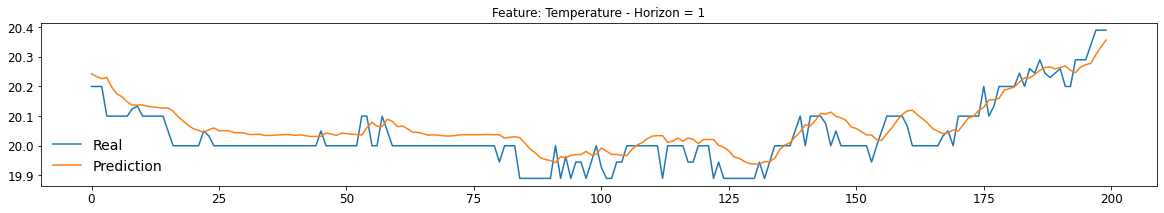

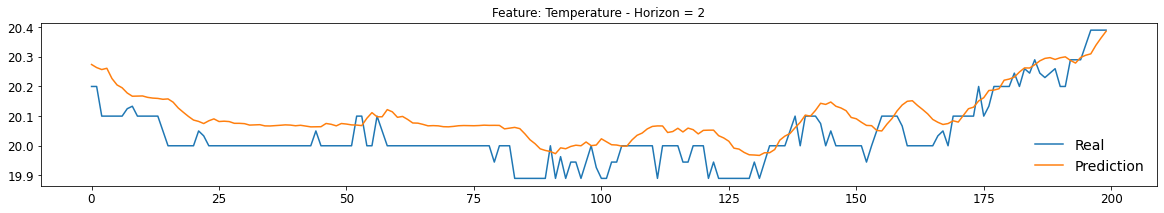

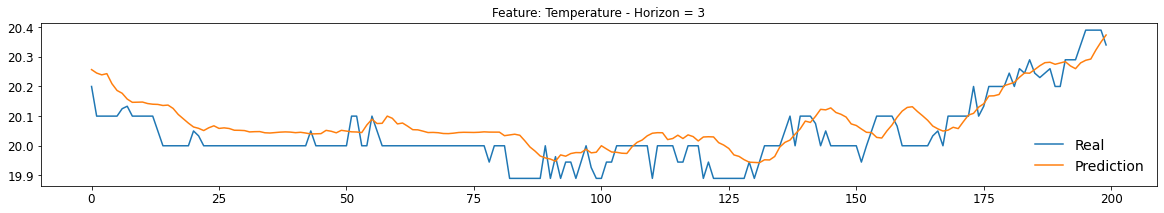

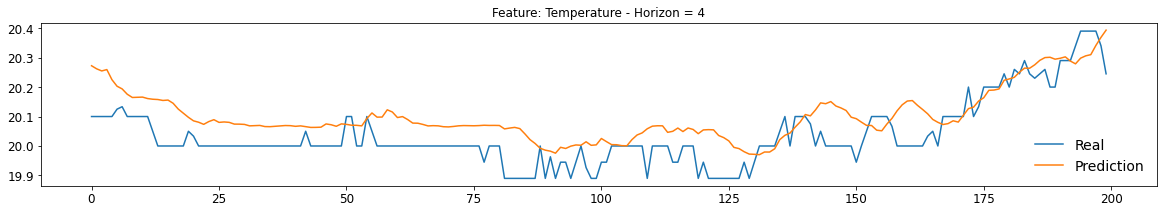

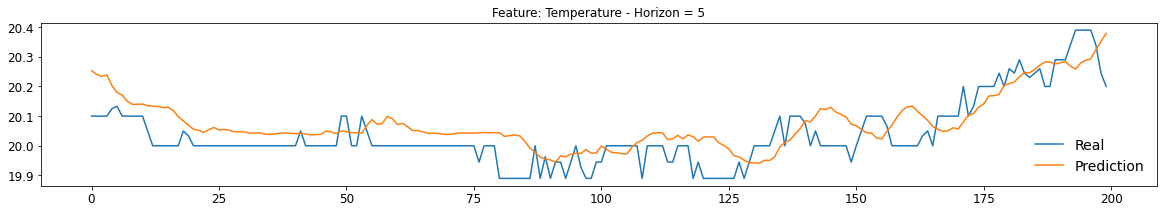

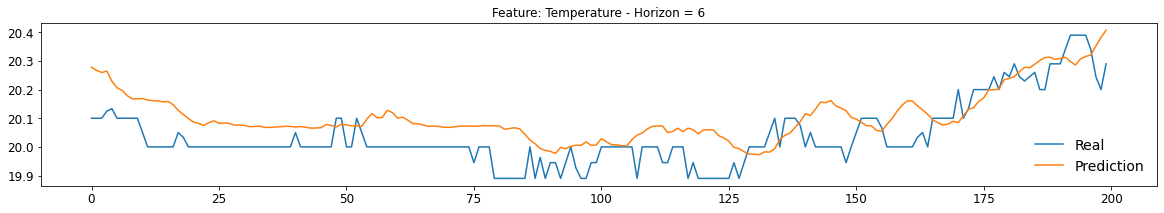

In [27]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices['Real']       = scaler.inverse_transform( testY[:,  i] )
    Prices['Prediction'] = scaler.inverse_transform( pred[:, i]   )



    # Apply inverse transformation   
    #
    if (Transformation == True):
        Prices = np.exp( Prices )
            
            
    # Plot Real & Predicted values
    #
    Prices[:200].plot( figsize = (20, 3) )
    #
    plt.title('Feature: {} - Horizon = {}'.format(targetSeries, i+1))
    plt.legend( frameon = False, fontsize = 14)
    plt.xticks(size = 12)
    plt.yticks(size = 12)
    plt.show()        

## Examples

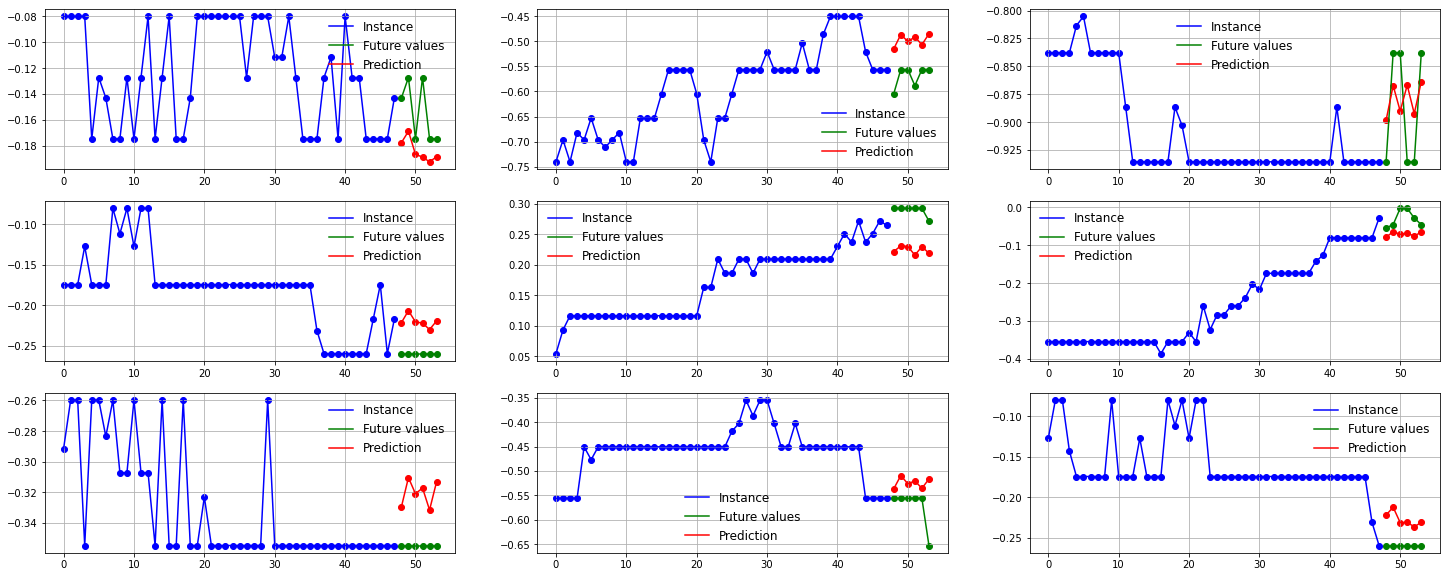

In [28]:
subplots = [331, 332, 333, 334, 335, 336,  337, 338, 339]
plt.figure( figsize = (25, 10) )
RandomInstances = [random.randint(1,testY.shape[0]) for i in range(0, 9)]

for plot_id, i in enumerate(RandomInstances):

    plt.subplot(subplots[plot_id])
    plt.grid()
    plot_scatter(range(0, Lag), testX[i], color='b')
    plot_scatter(range(Lag, Lag + Horizon), testY[i], color='g')
    plot_scatter(range(Lag, Lag + Horizon), pred[i].detach().numpy(), color='r')

    plt.legend(['Instance', 'Future values', 'Prediction'], frameon = False, fontsize = 12)
plt.show()